# Lab 10: Q-Learning {-}
Welcome to the 10th DS102 lab! 

The goal of this lab is to explore Q-Learning.

The code you need to write is commented out with a message "TODO: fill ...". There is additional documentation for each part as you go along.

## Collaboration Policy {-}
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Gradescope Submission {-}
To submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Sunday, April 25, 2021 at 11:59 PM. PST**

## Collaborators {-}
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

In [1]:
import copy
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Defining the GridWorld class {-}
We begin by defining a class for the environment in which we will run Q-learning. This is the grid world from class where we can have both a stochastic or deterministic environment. In the stochastic case the agent will have a probability of 0.8 of going in the direction it's told to go, and a probability of 0.1 of going in each direction orthogonal to the direction it's meant to go in.

In [2]:
FORWARD_PROB = 0.8
LEFT_PROB = 0.1
RIGHT_PROB = 0.1
BACKWARD_PROB = 0.0
FIXED_PROB = 0.0
class GridWorld():
    """The grid world class.
    
    Inputs:
        grid : list of list of str
            The starting representation of the world. A single element
            must be "R" which represents the starting location of the robot.
            Any element that is "" represents a cell on which the robot can travel,
            "X" represents a rock which the robot can not travel on, and any
            cell with a string that can be converted to a number represents
            a terminal state with its corresponding reward.
        stochastic : bool
            Whether the environment is stochastic or deterministic.

    """
    def __init__(self, grid, stochastic):
        self._grid = grid
        self.num_rows = len(grid)
        self.num_cols = len(grid[0])
        self._stochastic = stochastic
        # Determine the starting location of the robot.
        for i in range(self.num_rows):
            for j in range(self.num_cols):
                if self._grid[i][j] == "R":
                    self._grid[i][j] = ""
                    self._row_pos = i
                    self._col_pos = j
                    self._start_row_pos = i
                    self._start_col_pos = j

    def reset(self):
        """Reset the environment to its original state."""
        self._row_pos = self._start_row_pos
        self._col_pos = self._start_col_pos
        return (self._row_pos, self._col_pos)
        
    def step(self, action):
        """Move the robot a single step in the world.
        
        Inputs:
            action : str
                The desired direction to travel in. Can either be
                "north", "west", "east", "south".
            
        Outputs:
            pos : tuple of int
                The location the robot ends up at after taking a step.
                The first element represents the row and the second element
                represents the column.
            reward : float
                The reward from taking this step.
            done : bool
                Whether the robot has reached a terminal state or not.

        """
        # Determine the transition probabilities based on the action and
        # whether the environment is stochastic or deterministic.
        if self._stochastic:
            if action == "north":
                transition_probs = {
                    "north": FORWARD_PROB,
                    "west": LEFT_PROB,
                    "east": RIGHT_PROB,
                    "south": BACKWARD_PROB,
                    "fixed": FIXED_PROB
                }
            if action == "west":
                transition_probs = {
                    "north": RIGHT_PROB,
                    "west": FORWARD_PROB,
                    "east": BACKWARD_PROB,
                    "south": LEFT_PROB,
                    "fixed": FIXED_PROB
                }
            if action == "east":
                transition_probs = {
                    "north": LEFT_PROB,
                    "west": BACKWARD_PROB,
                    "east": FORWARD_PROB,
                    "south": RIGHT_PROB,
                    "fixed": FIXED_PROB
                }
            if action == "south":
                transition_probs = {
                    "north": BACKWARD_PROB,
                    "west":RIGHT_PROB,
                    "east": LEFT_PROB,
                    "south": FORWARD_PROB,
                    "fixed": FIXED_PROB
                }
        else:
            transition_probs = {
                "north": 0.0,
                "west": 0.0,
                "east": 0.0,
                "south": 0.0,
                "fixed": 0.0
            }
            transition_probs[action] = 1.0
            
        # Account for the cases where we are on the boundaries or
        # next to a rock.
        row = self._row_pos
        col = self._col_pos
        if row == 0 or self._grid[row - 1][col] == "X":
            transition_probs["fixed"] += transition_probs["north"]
            transition_probs["north"] = 0.0
        if col == 0 or self._grid[row][col - 1] == "X":
            transition_probs["fixed"] += transition_probs["west"]
            transition_probs["west"] = 0.0
        if row == self.num_rows - 1 or self._grid[row + 1][col] == "X":
            transition_probs["fixed"] += transition_probs["south"]
            transition_probs["south"] = 0.0
        if col == self.num_cols - 1 or self._grid[row][col + 1] == "X":
            transition_probs["fixed"] += transition_probs["east"]
            transition_probs["east"] = 0.0

        # Decide which direction the robot will go.
        directions = list(transition_probs.keys())
        probs = list(transition_probs.values())
        move = np.random.choice(directions, p=probs)
        if move == "north":
            self._row_pos -= 1
        elif move == "west":
            self._col_pos -= 1
        elif move == "east":
            self._col_pos += 1
        elif move == "south":
            self._row_pos += 1

        # Check if we are on a final state and determine the reward.
        if self._grid[self._row_pos][self._col_pos] != "":
            reward = float(self._grid[self._row_pos][self._col_pos])
            done = True
        else:
            reward = 0.0
            done = False
            
        return (self._row_pos, self._col_pos), reward, done
            
    def render(self):
        """Print an ASCII visualization of the world."""
        for i, row in enumerate(self._grid):
            row_strs = []
            for j, elt in enumerate(row):
                sys.stdout.write(" -----")
                if i == self._row_pos and j == self._col_pos:
                    elt = "R"
                row_strs.append(elt.center(5))
            sys.stdout.write("\n")
            sys.stdout.write("|" + "|".join(row_strs) + "|")
            sys.stdout.write("\n")
        for _ in range(self.num_cols):
            sys.stdout.write(" -----")
        sys.stdout.flush()


# Question 1: Setting up Q-Learning {-}
In this lab, we will implement Q-learning for the grid world environment defined above. Recall that the optimal Q-function at a given state $s$ for an action $a$ is defined as
$$Q(s, a) = \sum_{s'} P(s'| a, s)\left[R(s, a, s') + \gamma \max_{a'} Q(s', a')\right]$$
where $\gamma$ is the discount factor, $P(s'| s,a)$ is the state transition probability function, and $R(s, a, s')$ is the reward function.

## 1.a:  Learning the Q function {-}

Recall that we can learn the Q-function by updating our estimate of the optimal Q-function by averaging over the states and actions we observe. For example, say we have some estimate of the Q-function $\hat{Q}_k$ after observing $k$ samples, and say we observe a new sample which consists of $s$ the state we were at, $a$ the action we performed, $s'$ the state we ended up at, and $r$ the reward we got. Then our updated $Q$ function is given by
$$\hat{Q}_{k + 1}(s, a) \leftarrow (1 - \alpha)\hat{Q}_k(s, a) + \alpha \left[r + \gamma\max_{a'} \hat{Q}_k(s', a')\right]$$
where $\alpha$ is a parameter between $0$ and $1$ that we set.

### Fill in the function below, which updates the Q function using observed samples. {-}

In [3]:
# TODO: complete the function for updating Q. 
def update_Q(Q_values, old_state, action, new_state, reward, gamma, alpha):
    """Given an old estimate of the Q function (given by the Q_values dict),
    compute a new estimate by using observed samples.
    
    Modifies the Q_values dict in place, and does not return anything.
    
    Inputs:
        Q_values : dict of dict
            The estimate of the optimal Q values. The first index is over states
            while the second index is over actions. So for example
            Q_values[(1, 2)]["north"] is the Q-value for the state at position
            (1, 2) and with action "north".
        old_state : tuple of int
            The state we were previously at before making the given action. The
            first index represents the row while the second index represents the
            column of the state.
        action : string
            The action we made. Can either be "north", "east", "west" or "south".
        new_state : tuple of int
            The state we transitioned to after making the given action.
        reward : float
            The reward we obtained after making our action.
        gamma : float
            The discount factor for the Q-function.
        alpha : float
            The proportion that tells us how we will weigh new incoming estimates of Q.
    """
    # First compute the maximum Q-value at the new state.
    max_Q = max(Q_values[new_state].values()) #TODO: fill in

    # Now update the new Q value estimates.
    Q_values[old_state][action] = ((1 - alpha) * Q_values[old_state][action]
                                   + alpha * (reward + gamma * max_Q)) # TODO: fill in
    
    return Q_values

In [4]:
# Do not modify: Validation tests
old_state_test = (1,1)
action_test = 'west'
new_state_test = (1,2)
Q_values_test = {(0, 0): {'north': 10.2, 'west': 8.3, 'east': -5.0, 'south': 8.1},
                 (0, 1): {'north': 8.2, 'west': -4.2, 'east': -7.7, 'south': 20.1},
                 (0, 2): {'north': 16.6, 'west': 27.9, 'east': 19.5, 'south': 13.3},
                 (0, 3): {'north': -2.0, 'west': 3.4, 'east': -2.4, 'south': 0.9},
                 (0, 4): {'north': 0.6, 'west': -3.9, 'east': 16.3, 'south': 12.5},
                 (1, 0): {'north': 25.9, 'west': 20.4, 'east': -5.2, 'south': -5.0},
                 (1, 1): {'north': 9.6, 'west': 38.5, 'east': 5.2, 'south': 8.7},
                 (1, 2): {'north': 6.7, 'west': 18.4, 'east': 12.3, 'south': 28.8},
                 (1, 3): {'north': -4.8, 'west': 24.9, 'east': 3.9, 'south': 14.4},
                 (1, 4): {'north': 25.1, 'west': 21.6, 'east': 14.6, 'south': 16.4},
                 (2, 0): {'north': 11.0, 'west': 21.9, 'east': 2.1, 'south': -4.1},
                 (2, 1): {'north': 10.9, 'west': 10.9, 'east': 11.3, 'south': 15.0},
                 (2, 2): {'north': 19.2, 'west': 13.6, 'east': 2.7, 'south': -0.6},
                 (2, 3): {'north': 7.2, 'west': 16.1, 'east': 3.2, 'south': 2.1},
                 (2, 4): {'north': 10.9, 'west': 19.7, 'east': 19.4, 'south': -6.1}}
reward_test_list = [-10, 0, 10, 100]
output_test = [34.465, 35.965, 37.465, 50.965]
for i,reward_test in enumerate(reward_test_list):
    updated_Q_values_test = update_Q(copy.deepcopy(Q_values_test), old_state_test, action_test, 
                                     new_state_test, reward_test, 0.75, 0.15)
    cur_out = updated_Q_values_test[old_state_test][action_test] 
    assert np.abs(output_test[i]-cur_out)<0.01
print('Test Passed!')

Test Passed!


## 1.b. Agents that use the Q function {-}

Now that we've defined the Q function, we will also define two types of agents:

1. greedy agent: The first type of agent always picks the best estimate of the Q-function.
2. $\epsilon$-greedy agent: The second type picks the best estimate of the Q-function with probability $1-\epsilon$, and picks a random action uniformly from the action space with probability $\epsilon$. 

The first type is called a greedy agent while the second type is called an $\epsilon$-greedy agent. We will explore why $\epsilon$-greedy agents are sometimes useful. 

First we will define a few helper functions:

In [5]:
def random_action():
    """Return a random action."""
    return np.random.choice(["north", "south", "east", "west"])

def init_Q(env):
    """Return initial Q-value estimates with all values 0."""
    Q_values = {}
    for i in range(env.num_rows):
        for j in range(env.num_cols):
            Q_values[i, j] = {
                "north": 0.0,
                "west": 0.0,
                "east": 0.0,
                "south": 0.0
            }
    return Q_values

### Fill in the `run_agent` function below that runs both of these types of agents. {-}

Note: Because of the randomness inherent in the function, you will have to search through the actions in the order "north", "west", "east", "south" when looking for which arms have the maximum value and you will have to use `np.random.choice` to choose.

In [6]:
# TODO: fill in the best actions for the agent in the run_agent function.
# The run_agent function can run either the greedy agent or the epsilon-greedy agent, 
# depending on the parameter epsilon that gets passed in.
    
def run_agent(Q_values, env, num_rollouts, gamma=0.9, alpha=0.1, epsilon=0.0, render=False):
    """Run a Q-learning agent in a given environment.
    
    Inputs:
        Q_values : dict of dict
            The Q value estimates to start from.
        env : GridWorld
            The environment in which to run the agent.
        num_rollouts : int
            The number of times we wish to reset the environment
            to its original state.
        gamma : float
            The discount factor for the Q-function.
        alpha : float
            The proportion that tells us how we will weigh new incoming estimates of Q.
        epsilon : float
            The proportion of times the agent will randomly pick an action instead
            of making the optimal move in terms of the current estimate Q-function.
            If epsilon is set to 0 this corresponds to a greedy agent.
        render : bool
            Whether to print the environment as it goes through each iteration.
    
    Returns:
        Q_values : dict of dict
            The learned Q values. The first index is over states
            while the second index is over actions. So for example
            Q_values[(1, 2)]["north"] is the Q-value for the state at position
            (1, 2) and with action "north".
    """
    for i in range(num_rollouts):
        state = env.reset()
        if render:
            time.sleep(0.8)
            clear_output(wait=True)
            env.render()
        done = False
        samples = []
        while not done:
            if np.random.binomial(1, epsilon):
                action = random_action() # take random action
            else:
                # Take the best action according to the Q-value estimate.
                # If multiple values are equal, randomly chose between them.
                
                # TODO: fill in a list of all actions that have the highest Q-value estimate.
                # If there is more than one action with the highest Q-value estimate, 
                # include them all in the list.
                best_actions = []
                best_value = -float("inf")
                for action, value in Q_values[state].items():
                    if value > best_value:
                        best_actions = [action]
                        best_value = value
                    elif value == best_value:
                        best_actions.append(action)
                val = Q_values[state]
                action = np.random.choice(best_actions)
            old_state = state
            state, reward, done = env.step(action) # update state
            samples.append((old_state, action, state, reward))
            if render:
                time.sleep(0.5)
                clear_output(wait=True)
                env.render()
        # Update the Q-function using samples from this rollout.
        for old_state, action, state, reward in reversed(samples):
            Q_values = update_Q(Q_values, old_state, action, state, reward, gamma, alpha)
    return Q_values

In [7]:
# Do not modify: Validation tests
np.random.seed(0)
env_test = GridWorld([["R", "", "100",  "X", ],
                      ["", "X", "X", "X"],
                      ["", "", "",  "100"]], stochastic=False)
Q_values_test = init_Q(env_test)
Q_values_test = run_agent(Q_values_test, env_test, 1000, alpha=0.5, render=False) 
output_test = {(0, 0): {'north': 3.345, 'west': 5.017, 'east': 0.0, 'south': 65.610},
               (0, 1): {'north': 0.0, 'west': 0.0, 'east': 0.0, 'south': 0.0},
               (0, 2): {'north': 0.0, 'west': 0.0, 'east': 0.0, 'south': 0.0},
               (0, 3): {'north': 0.0, 'west': 0.0, 'east': 0.0, 'south': 0.0},
               (1, 0): {'north': 3.345, 'west': 8.458,'east': 3.075,'south': 72.9},
               (1, 1): {'north': 0.0, 'west': 0.0, 'east': 0.0, 'south': 0.0},
               (1, 2): {'north': 0.0, 'west': 0.0, 'east': 0.0, 'south': 0.0},
               (1, 3): {'north': 0.0, 'west': 0.0, 'east': 0.0, 'south': 0.0},
               (2, 0): {'north': 6.664,'west': 12.530,'east': 81.0, 'south': 12.530},
               (2, 1): {'north': 22.781, 'west': 4.556, 'east': 90.0, 'south': 25.313},
               (2, 2): {'north': 43.594, 'west': 20.25, 'east': 100.0, 'south': 33.75},
               (2, 3): {'north': 0.0, 'west': 0.0, 'east': 0.0, 'south': 0.0}}
for state, state_dict in Q_values_test.items():
    for action, q_val in state_dict.items():
        assert np.abs(q_val - output_test[state][action])  < 0.01
        
print('Test Passed!')

Test Passed!


## Question 2. Q-learning in a deterministic setting {-}
Now let's observe the behavior of the greedy agent vs. the $\epsilon$-greedy agent. We consider a two-path setting where the agent can either receive a small reward by following a short path or a large reward by following a long path. In this setting, for any set of actions, the reward is deterministic.

In the printed Grid World, R represents the agent, X's represent obstacles, and numbers represent rewards for reaching those positions.

### First, we will observe the behavior of the the greedy agent {-}

In [8]:
# No coding TODOs here, just run this cell to observe what the greedy agent does.
np.random.seed(0)

# Initialize the world.
env = GridWorld([["",  "", "", "", "", "100",  "X", ],
                 ["",  "X", "X", "X", "X", "X", "X"],
                 ["",  "", "", "", "R", "",  "1"]], stochastic=False)

# Initialize the Q-value estimates.
Q_values = init_Q(env)

# Learn the Q-value for 100 rollouts.
Q_values = run_agent(Q_values, env, 100, alpha=0.5, render=False)

# Now let's see what the agent plays after learning the Q-values.
Q_values = run_agent(Q_values, env, 1, render=True)

 ----- ----- ----- ----- ----- ----- -----
|     |     |     |     |     | 100 |  X  |
 ----- ----- ----- ----- ----- ----- -----
|     |  X  |  X  |  X  |  X  |  X  |  X  |
 ----- ----- ----- ----- ----- ----- -----
|     |     |     |     |     |     |  R  |
 ----- ----- ----- ----- ----- ----- -----

### 2.a Which reward did the agent go for? Why do you think this happened? {-}

 The agent chose the smaller reward since in the first few runs it will build Q-values faster for the closer reward. Once it has a non-zero Q-value path for that reward that leads to the smaller reward it will always take it, never learning the Q-values that will lead it to the larger reward.

### 2.b Now let's try to run a simple $\epsilon$-greedy agent in this setting. {-}
Let's try setting $\epsilon$ to 0.3 in this case.

In [9]:
# No coding TODOs here, just run this cell to observe what the epsilon-greedy agent does.
np.random.seed(0)

# Initialize the Q-value estimates.
Q_values = init_Q(env)

# Learn the Q-value for 100 rollouts.
Q_values = run_agent(Q_values, env, 100, epsilon=0.6, alpha=1.0, render=False)
# Now let's see what the agent plays after learning the Q-values.
Q_values = run_agent(Q_values, env, 1, render=True)

 ----- ----- ----- ----- ----- ----- -----
|     |     |     |     |     | 100 |  X  |
 ----- ----- ----- ----- ----- ----- -----
|     |  X  |  X  |  X  |  X  |  X  |  X  |
 ----- ----- ----- ----- ----- ----- -----
|     |     |     |     |     |     |  R  |
 ----- ----- ----- ----- ----- ----- -----

### What did the $\epsilon$-greedy agent do? If it was different from the greedy agent, why do you think this happened? {-}

Setting epsilon causes the agent to go for the higher reward since we are able to randomly go to that higher reward often enough to learn Q-values that will bring us to that higher reward value.

## Question 3. Q-learning in a stochastic setting {-}
Now let's consider the stochastic setting. In stochastic Grid World, the agent moves in its chosen direction with probability 0.8, and moves in each direction orthogonal to the direction it had meant to go in with probability 0.1. We'll consider a setting where we have a bridge that leads to a high-value end-state. However, crossing carries with it a risk of falling down the side of the bridge.

For this simulation, we will just look at an $\epsilon$-greedy agent with $\epsilon = 0.3$. This time, we will observe the effects of changing the the discount factor $\gamma$ for the Q-function.

### 3.a In the cell below, test some different values of $\gamma$ and try to find a value of $\gamma$ that will lead the agent to try to cross the bridge and a value of $\gamma$ that will lead the agent to take the lower valued option. {-}

There aren't any special characters to mark the bridge here, the bridge is just represented by the two blank squares with -100's on either side. The agent has a small chance of falling into a squares with -100 reward when passing through each of these "bridge" squares. 

In [10]:
# TODO: run this cell with different values of gamma.
np.random.seed(0)

# Initialize the world.
env = GridWorld([["",  "", "", "", "", "", "",  "-100", "-100", ""],
                 ["1", "", "", "", "", "R", "","", "","200"],
                 ["",  "", "", "", "", "", "",  "-100", "-100", ""]], stochastic=True)

# Initialize the Q-value estimates.
Q_values = init_Q(env)

# Learn the Q-value for 1000 rollouts.
# Try different values of gamma from 0.1 to 0.9
Q_values = run_agent(Q_values, env, 1000, epsilon=0.3, gamma=0.6, alpha=0.1, render=False)

# Now let's see what the agent plays after learning the Q-values.
Q_values = run_agent(Q_values, env, 1, render=True)

 ----- ----- ----- ----- ----- ----- ----- ----- ----- -----
|     |     |     |     |     |     |     | -100| -100|     |
 ----- ----- ----- ----- ----- ----- ----- ----- ----- -----
|  1  |     |     |     |     |     |     |     |     |  R  |
 ----- ----- ----- ----- ----- ----- ----- ----- ----- -----
|     |     |     |     |     |     |     | -100| -100|     |
 ----- ----- ----- ----- ----- ----- ----- ----- ----- -----

### What values of gamma did you use to achieve each behavior? Why did these values work? {-}

Lower values of $\gamma$ result in the robot moving towards the lower reward which has lower risk. On the other hand, higher values of $\gamma$ lead the robot towards the higher but more risky reward.
 
A larger value of $\gamma$ puts more weight on the best case future potential of a state, thus it favors riskier but higher reward paths.

Yay, you've made it to the end of Lab 10!


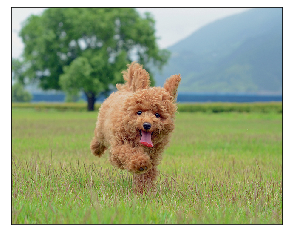

In [11]:
import matplotlib.image as mpimg
img = mpimg.imread('cute_poodle.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
print("Yay, you've made it to the end of Lab 10!")
plt.show()